<a href="https://colab.research.google.com/github/Afififaiz/Day3_AiNusantara/blob/main/Simple_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple CNN Model

In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm

1. Data loading
2. Define model
4. Train and evaluate model

## Configurations

In [ ]:
image_size = 224
batch_size = 8
num_workers = 2
learning_rate = 1e-4
num_epoch = 200

## Data Loading

In [ ]:
train_set = torchvision.datasets.Imagenette(root='./data', split='train',
                                          download=True, transform=transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                                        transforms.ToTensor()]))

100%|██████████| 1557161267/1557161267 [00:49<00:00, 31547297.53it/s]


Extracting ./data/imagenette2.tgz to ./data


In [ ]:
val_set = torchvision.datasets.Imagenette(root='./data', split='val',
                                          download=False, transform=transforms.Compose([transforms.Resize((image_size, image_size)),
                                                                                        transforms.ToTensor()]))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [ ]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

In [ ]:
label_count = count_samples_per_class(train_set)
num_classes = len(label_count)
print("Total number of data: ", len(train_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  9469
Number of classes: 10
Number of data samples per class: Counter({2: 993, 0: 963, 6: 961, 9: 960, 5: 956, 1: 955, 8: 951, 4: 941, 7: 931, 3: 858})


In [ ]:
label_count = count_samples_per_class(val_set)
num_classes = len(label_count)
print("Total number of data: ", len(val_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  3925
Number of classes: 10
Number of data samples per class: Counter({7: 419, 4: 409, 8: 399, 1: 395, 5: 394, 9: 390, 6: 389, 0: 387, 3: 386, 2: 357})


### Visualize the dataset

In [ ]:
cat_to_name = {'1': 'tench', '2': 'English springer', '3': 'cassette player', '4':'chain saw', '5':'church', '6':'French horn', '7':'garbage truck', '8':'gas pump', '9':'golf ball', '10':'parachute'}
def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = [axes]  # Make it iterable

    # Check if axes is still not iterable
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])


    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            # imshow(images_batch[i], ax, labels[i].item())
            imshow(images_batch[i], ax, cat_to_name[str(labels[i].item() + 1)])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

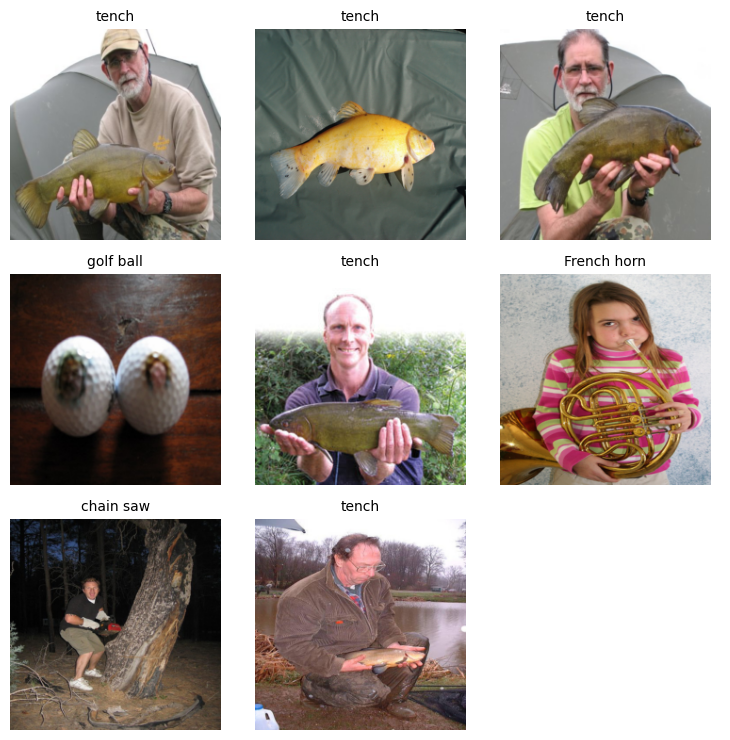

In [ ]:
for idx, data in enumerate(train_loader):

  show_images_batch(images_batch=data[0], labels=data[1])
  break

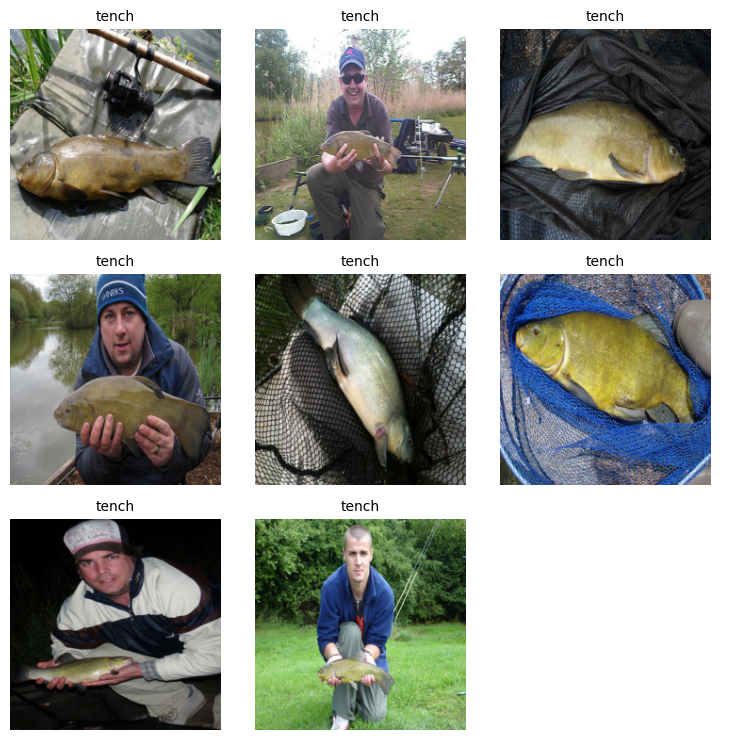

In [ ]:
for idx, data in enumerate(val_loader):

  show_images_batch(images_batch=data[0], labels=data[1])
  break

## CNN Model

In [ ]:
num_class = 10

class CNNModel(nn.Module):

  def __init__(self,
               image_depth):

    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=image_depth, out_channels=256, kernel_size=3, stride=1, padding=1) #size: 224
    self.pool = nn.MaxPool2d(2, 2) #size: 112
    self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1) #size: 112
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1) #size: 112
    #self.pool = nn.MaxPool2d(2, 2) #size: 56
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2) #size: 56
    self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=5, stride=1, padding=2) #size: 56
    #self.pool = nn.MaxPool2d(2, 2) #size: 28
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=7, stride=1, padding=3) #size: 28
    #self.pool = nn.MaxPool2d(2, 2) #size: 14


    self.fc1 = nn.Linear(14*14*1024, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, num_class)


  def forward(self, x):

    #first layer and first pool
    x = F.relu(self.conv1(x))
    x = self.pool(x)

    #second and third layer followed by pool
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = self.pool(x)

    #fourth and fifth conv and pool
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.pool(x)

    #final conv and pool
    x = F.relu(self.conv6(x))
    x = self.pool(x)

    #fully-connected classifiers.
    x = torch.flatten(x, start_dim=1) #we need to all the dimensions except the batch.
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x




In [ ]:
model = CNNModel(image_depth=3)

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 224, 224]           7,168
         MaxPool2d-2        [-1, 256, 112, 112]               0
            Conv2d-3        [-1, 256, 112, 112]         590,080
            Conv2d-4        [-1, 256, 112, 112]         590,080
         MaxPool2d-5          [-1, 256, 56, 56]               0
            Conv2d-6          [-1, 512, 56, 56]       3,277,312
            Conv2d-7          [-1, 512, 56, 56]       6,554,112
         MaxPool2d-8          [-1, 512, 28, 28]               0
            Conv2d-9         [-1, 1024, 28, 28]      25,691,136
        MaxPool2d-10         [-1, 1024, 14, 14]               0
           Linear-11                 [-1, 1024]     205,521,920
           Linear-12                  [-1, 512]         524,800
           Linear-13                   [-1, 10]           5,130
Total params: 242,761,738
Trainable par

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

## Train & Evaluate the model

In [ ]:

# best_val_accuracy = 0
# for epoch_idx in range(num_epoch):

#   train_running_loss = 0.0
#   train_running_accuracy = 0.0

#   idx = 0
#   for idx, data in tqdm(enumerate(train_loader)):

#     optimizer.zero_grad()

#     images, labels = data
#     # images = images.cuda()
#     # labels = labels.cuda()

#     pred = model(images)

#     loss = loss_fn(pred, labels)

#     loss.backward()
#     optimizer.step()

#     train_running_loss += loss.item()

#     _, pred_arr = torch.max(pred.detach(), 1)
#     label_arr = labels.cpu().numpy()


#     train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

#   print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
#   print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

#   val_running_loss = 0.0
#   val_running_accuracy = 0.0
#   idx = 0
#   for idx, data in tqdm(enumerate(val_loader)):


#     images, labels = data
#     images = images.cuda()
#     labels = labels.cuda()

#     pred = model(images)

#     loss = loss_fn(pred, labels)

#     val_running_loss += loss.item()

#     _, pred_arr = torch.max(pred.detach(), 1)
#     label_arr = labels.cpu().numpy()


#     val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

#   print(f"Validation Loss at epoch {epoch_idx} is {val_running_loss}")
#   print(f"Validation Accuracy at epoch {epoch_idx} is {val_running_accuracy/(idx+1)}")


#   if best_val_accuracy < val_running_accuracy/idx:

#     torch.save(model.state_dict(), f"saved_model-{epoch_idx}.pth.tar")
#     best_val_accuracy = val_running_accuracy/idx

#     print(f"Model saved at epoch {epoch_idx} with val accuracy of {best_val_accuracy}")

2it [02:50, 85.15s/it]


KeyboardInterrupt: 

## Load the trained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/saved_model-7.pth.tar', map_location=torch.device('cpu')))

<All keys matched successfully>

### Evaluate the trained model

In [ ]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(val_loader):


  images, labels = data
  images = images
  labels = labels

  pred = model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 5:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 8.467313268163707
Validation Accuracy is 0.8333333333333334


In [ ]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save all the conv layers in this list
# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])

print(f"Total convolutional layers: {counter}")

Total convolutional layers: 6


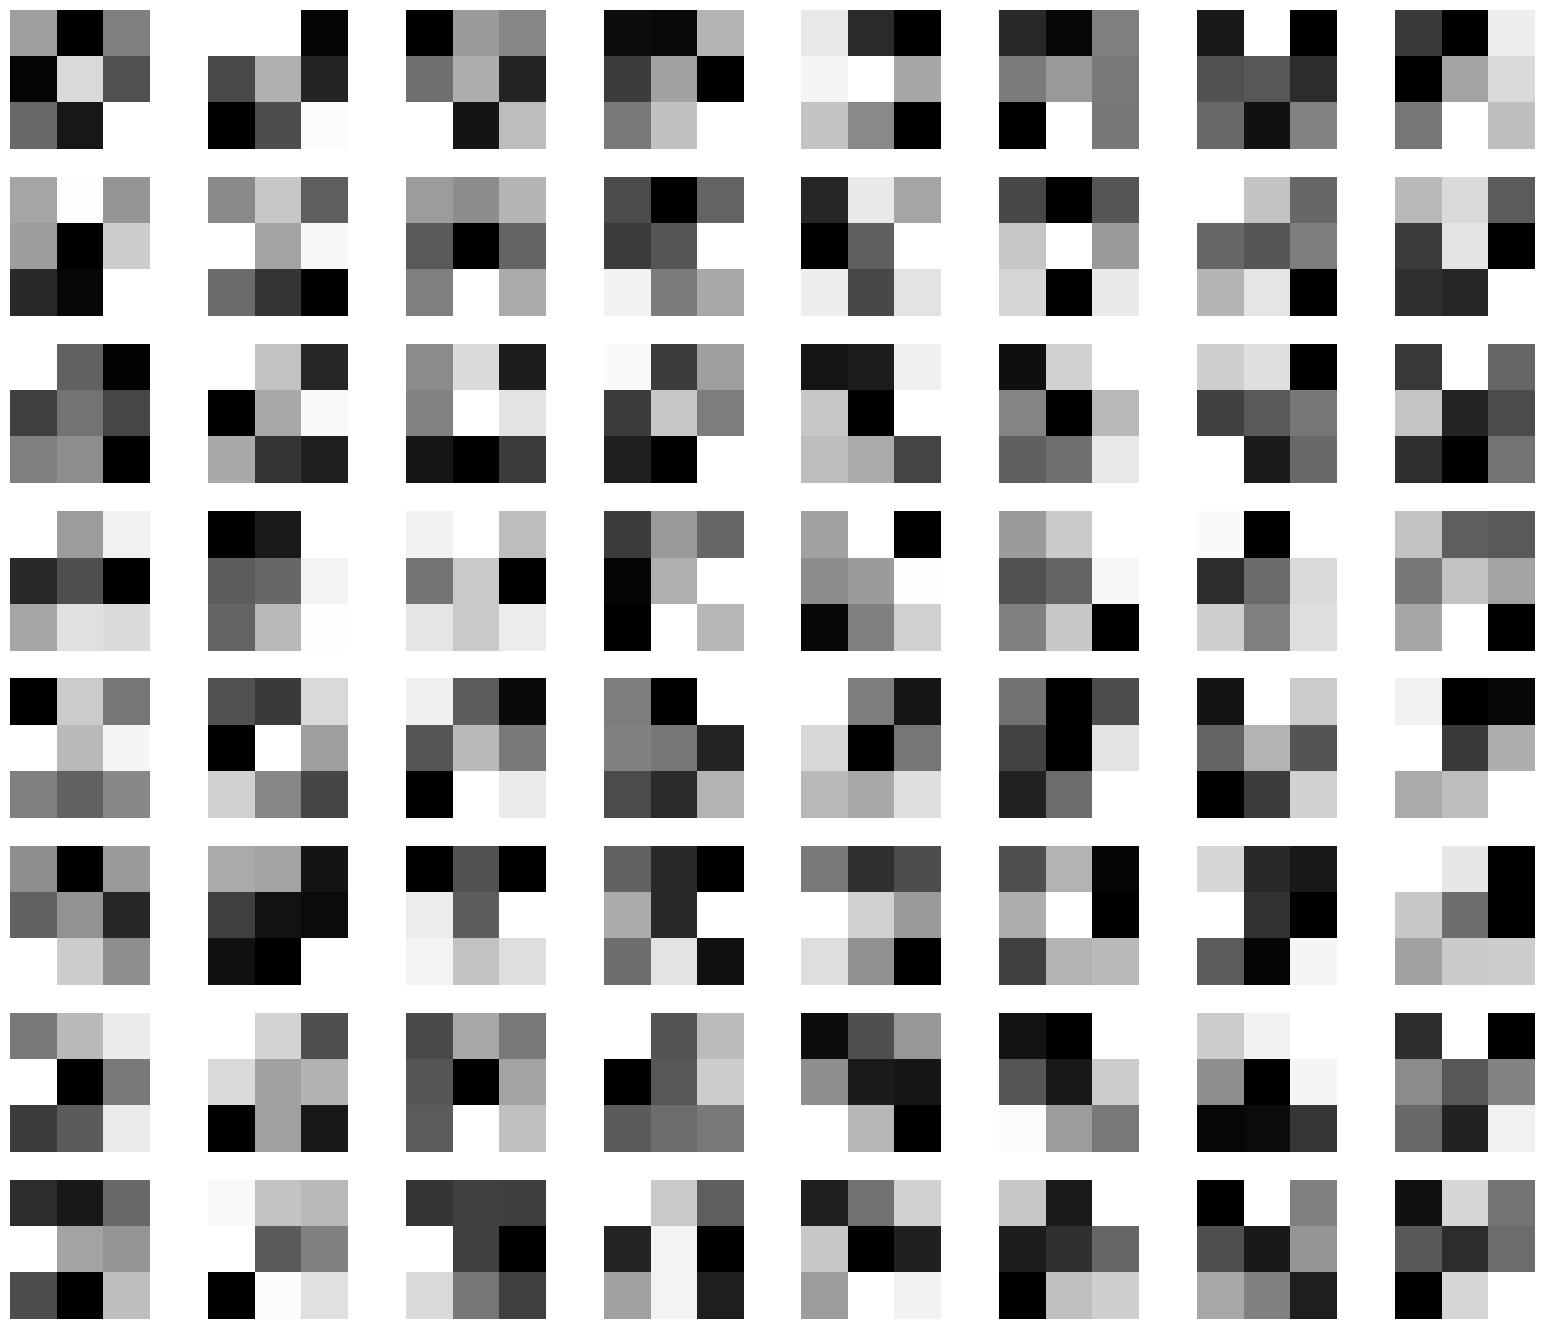

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    if i == 64:
      break
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('./filter.png')
plt.show()

### Visualize the output of filters

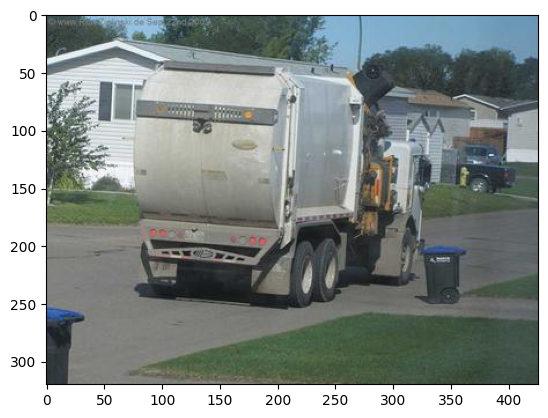

torch.Size([1, 3, 224, 224])


In [ ]:
# read and visualize an image
img = cv2.imread('test2.JPEG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [ ]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64:
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"./layer_lorry_{num_layer}.png")
    # plt.show()
    plt.close()

torch.Size([256, 224, 224])
Saving layer 0 feature maps...
torch.Size([256, 224, 224])
Saving layer 1 feature maps...
torch.Size([256, 224, 224])
Saving layer 2 feature maps...
torch.Size([512, 224, 224])
Saving layer 3 feature maps...
torch.Size([512, 224, 224])
Saving layer 4 feature maps...
torch.Size([1024, 224, 224])
Saving layer 5 feature maps...
